# Imports

In [1]:
import dill as pickle
import json
import numpy as np
import os
import re
import sys
import h5py
import torch
import matplotlib.pyplot as plt
# Can replace with your own path
sys.path.append(os.path.abspath('/alt-mt/work/durrani/aux_classifier/'))

import aux_classifier
from aux_classifier import data_loader
from aux_classifier import utils
#from aux_classifier import plotting
sys.modules['aux_classifier'] = aux_classifier

# Constants

In [19]:
# Results save directory
OUT_DIR = 'results/'

# Training setup
NUM_EPOCHS = 10
BATCH_SIZE = 128

L1 = 0.0001 
L2 = 0.0001

DIR='Representations/bert-base-cased'
MODEL=os.path.join(DIR,'aux_model')
JSON=os.path.join(DIR,'mapping.json')
nMap=os.path.join(DIR,'neuronMap.json')
TRAIN_SOURCE = os.path.join(DIR,'en_ewt-ud-train.conllu.word')
TRAIN_LABELS = os.path.join(DIR, 'en_ewt-ud-train.conllu.label')
TRAIN_ACTIVATIONS = os.path.join(DIR, 'en_ewt-ud-train.conllu.hdf5')
DEV_SOURCE = os.path.join(DIR,'en_ewt-ud-dev.conllu.word')
DEV_LABELS = os.path.join(DIR, 'en_ewt-ud-dev.conllu.label')
DEV_ACTIVATIONS = os.path.join(DIR, 'en_ewt-ud-dev.conllu.hdf5')
TEST_SOURCE = os.path.join(DIR, 'en_ewt-ud-test.conllu.word')
TEST_LABELS = os.path.join(DIR, 'en_ewt-ud-test.conllu.label')
TEST_ACTIVATIONS = os.path.join(DIR, 'en_ewt-ud-test.conllu.hdf5')

#NUM_NEURONS_PER_LAYER = 768
MAX_SENT_L = 1000
IS_BRNN = False
TASK_SPECIFIC_TAG = 'NN'

In [15]:
representations=h5py.File(TRAIN_ACTIVATIONS, "r")
sentRepresentation = torch.FloatTensor(representations["0"])
NUM_NEURONS_PER_LAYER = sentRepresentation.shape[2]

# Preprocessing

In [16]:
# Create required directories
os.makedirs(OUT_DIR, exist_ok=True)

In [20]:
print("Loading activations...")
train_activations, NUM_LAYERS = data_loader.load_activations(TRAIN_ACTIVATIONS, NUM_NEURONS_PER_LAYER, is_brnn=IS_BRNN)
dev_activations, _ = data_loader.load_activations(DEV_ACTIVATIONS, NUM_NEURONS_PER_LAYER, is_brnn=IS_BRNN)
test_activations, _ = data_loader.load_activations(TEST_ACTIVATIONS, NUM_NEURONS_PER_LAYER, is_brnn=IS_BRNN)
print("Number of train sentences: %d"%(len(train_activations)))
print("Number of dev sentences: %d"%(len(dev_activations)))
print("Number of test sentences: %d"%(len(test_activations)))

Loading activations...
Loading hdf5 activations from Representations/bert-base-cased/en_ewt-ud-test.conllu.hdf5...
Number of train sentences: 11733
Number of dev sentences: 1914
Number of test sentences: 1972


In [21]:
train_tokens = data_loader.load_data(TRAIN_SOURCE, TRAIN_LABELS, train_activations, MAX_SENT_L)
dev_tokens = data_loader.load_data(DEV_SOURCE, DEV_LABELS, dev_activations, MAX_SENT_L)
test_tokens = data_loader.load_data(TEST_SOURCE, TEST_LABELS, test_activations, MAX_SENT_L)
NUM_TOKENS = sum([len(t) for t in train_tokens['target']])

In [22]:
print('Number of total train tokens: %d'%(NUM_TOKENS))
NUM_SOURCE_TOKENS = sum([len(t) for t in train_tokens['source']])
print('Number of source words: %d'%(NUM_SOURCE_TOKENS)) 
NUM_NEURONS = train_activations[0].shape[1]
print('Number of neurons: %d'%(NUM_NEURONS))
print("Number of layers: %d" % (NUM_LAYERS))

Number of total train tokens: 199207
Number of source words: 199207
Number of neurons: 9984
Number of layers: 13


# Create Tensors

In [23]:
print("Creating train tensors...")
X, y, mappings = utils.create_tensors(train_tokens, train_activations, TASK_SPECIFIC_TAG)
print (X.shape)
print (y.shape)

Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
(199207, 9984)
(199207,)


In [24]:
print("Creating test tensors...")
X_test, y_test, mappings = utils.create_tensors(test_tokens, test_activations, TASK_SPECIFIC_TAG, mappings)
print("Creating dev tensors...")
X_dev, y_dev, mappings = utils.create_tensors(dev_tokens, dev_activations, TASK_SPECIFIC_TAG, mappings)

Creating test tensors...
Number of tokens:  24737
length of source dictionary:  19649
length of target dictionary:  17
24737
Total instances: 24737
['thirteen', 'trimmers', 'Hubris', 'straight', 'finish', 'reside', 'Looks', 'join', 'bit', 'bagh', 'Usamah', 'facsimile', 'Harvey', '4/14/00', 'bmw', 'sink', 'greatest', 'L', 'gifts', 'beat']
Creating dev tensors...
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']


In [25]:
label2idx, idx2label, src2idx, idx2src = mappings

# Get Accuracy with All neurons without Regularization

In [26]:
print("Building model...")
model = utils.train_logreg_model(X, y, lambda_l1=0, lambda_l2=0, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
overall_train_accuracies = utils.evaluate_model(model, X, y, idx2label)
overall_dev_accuracies = utils.evaluate_model(model, X_dev, y_dev, idx2label)
overall_test_accuracies, predictions = utils.evaluate_model(model, X_test, y_test, idx2label, return_predictions=True, source_tokens=test_tokens['source'])

print("=============================================")
print("Overall Train Accuracies")
print(overall_train_accuracies)

print("Overall Dev Accuracies")
print(overall_dev_accuracies)

print("Overall Test Accuracies")
print(overall_test_accuracies)
print("=============================================")

Building model...
Training classification model
Creating model...
Number of training instances: 199207
Number of classes: 17



Epoch: [1/10], Loss: 0.0021



Epoch: [2/10], Loss: 0.0015



Epoch: [3/10], Loss: 0.0013



Epoch: [4/10], Loss: 0.0012



Epoch: [5/10], Loss: 0.0011



Epoch: [6/10], Loss: 0.0010



Epoch: [7/10], Loss: 0.0009



Epoch: [8/10], Loss: 0.0008



Epoch: [9/10], Loss: 0.0008



Epoch: [10/10], Loss: 0.0007



Score (accuracy) of the model: 0.9797



Score (accuracy) of the model: 0.9528



Score (accuracy) of the model: 0.9510
Overall Train Accuracies
{'__OVERALL__': 0.9797346478788396, 'PUNCT': 0.9988628908812596, 'ADV': 0.9652157201883348, 'DET': 0.9981587903810746, 'PART': 0.9998155321896329, 'NOUN': 0.9568043370544173, 'SYM': 0.9618055555555556, 'PROPN': 0.9438028627195836, 'ADJ': 0.9635934191236357, 'VERB': 0.9867591660139495, 'AUX': 0.9801520814537956, 'NUM': 0.9654901960784313, 'CONJ': 0.998330044026112, 'PRON': 0.9986623351805848, 'X': 0.9587628865979382, 'SCONJ': 0.9797945205479452, 'INTJ': 0.9577464788732394, 'ADP': 0.9899536321483772}
Overall Dev Accuracies
{'__OVERALL__': 0.9527786700931578, 'PUNCT': 0.9956910838581372, 'ADV': 0.919431279620853, 'DET': 0.9919735599622285, 'PART': 0.9968051118210862, 'NOUN': 0.9242065371861677, 'SYM': 0.8360655737704918, 'PROPN': 0.8699945145364784, 'ADJ': 0.9199549041713642, 'VERB': 0.9681011134517002, 'AUX': 0.9496248660235799, 'NUM': 0.9251336898395722, 'CONJ': 0.9922978177150192, 'PRON': 0.9947671376242805, 'X': 0.7284768

# Get Accuracy with Selected neurons with Elastic-net (Retraining)

In [34]:
def findMinimalNeurons(X, y, X_dev, y_dev, X_train, y_train):
    bestTopNeurons = []
    bestRandomNeurons = []
    bestBottomNeurons = []
     
    print("Building model with: L1: " +  str(L1) + " L2: " + str(L2))
    model_temp = utils.train_logreg_model(X, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
    dev_accuracies = utils.evaluate_model(model_temp, X_dev, y_dev, idx2label, source_tokens=dev_tokens['source'])
    accuracyElastic = dev_accuracies['__OVERALL__']
    torch.save(model_temp, MODEL)
    with open(JSON, 'w') as fp:
        json.dump(mappings, fp)
        
    ordering, cutoffs = utils.get_neuron_ordering(model_temp, label2idx, search_stride=1000)
    for percentage in [0.05]: #[0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5]:
        top_neurons = ordering[:int(percentage*len(ordering))]
        print("Selecting %d top neurons" % (len(top_neurons)))
        X_filtered = utils.filter_activations_keep_neurons(top_neurons, X)
        X_dev_filtered = utils.filter_activations_keep_neurons(top_neurons, X_dev)
        X_test_filtered = utils.filter_activations_keep_neurons(top_neurons, X_test)
        model_temp = utils.train_logreg_model(X_filtered, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
        top_neurons_dev_accuracies = utils.evaluate_model(model_temp, X_dev_filtered, y_dev, idx2label, source_tokens=dev_tokens['source'])
        top_neurons_test_accuracies = utils.evaluate_model(model_temp, X_test_filtered, y_test, idx2label, source_tokens=test_tokens['source'])
        accuracyElasticTop = top_neurons_dev_accuracies['__OVERALL__']
        
        random_neurons = np.random.choice(ordering, size=len(top_neurons), replace=False)
        print("Selecting %d random neurons" % (len(random_neurons)))
        X_filtered = utils.filter_activations_keep_neurons(random_neurons, X)
        X_dev_filtered = utils.filter_activations_keep_neurons(random_neurons, X_dev)
        model_temp = utils.train_logreg_model(X_filtered, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
        random_neurons_dev_accuracies = utils.evaluate_model(model_temp, X_dev_filtered, y_dev, idx2label, source_tokens=dev_tokens['source'])
        accuracyElasticRandom = random_neurons_dev_accuracies['__OVERALL__']
        
        bottom_neurons = ordering[-int(percentage*len(ordering)):]
        print("Selecting %d bottom neurons" % (len(bottom_neurons)))
        X_filtered = utils.filter_activations_keep_neurons(bottom_neurons, X)
        X_dev_filtered = utils.filter_activations_keep_neurons(bottom_neurons, X_dev)
        model_temp = utils.train_logreg_model(X_filtered, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
        bottom_neurons_dev_accuracies = utils.evaluate_model(model_temp, X_dev_filtered, y_dev, idx2label, source_tokens=dev_tokens['source'])
        accuracyElasticBottom = bottom_neurons_dev_accuracies['__OVERALL__']
        
        print ("Accuracy with selected: " + str(percentage*100) + str("% = ") + str(len(top_neurons)) + str(" neurons"))
        print ("Overall Accuracy for this Lambda Set: " + str(accuracyElastic))
        print ("Top Neurons Accuracy: " + str(accuracyElasticTop))
        print ("Random Neuron Accuracy: " + str(accuracyElasticRandom))
        print ("Bottom Neuron Accuracy: " + str(accuracyElasticBottom))
    
    return



In [35]:
findMinimalNeurons(X, y, X_dev, y_dev, X_test, y_test)

Building model with: L1: 0.0001 L2: 0.0001
Training classification model
Creating model...
Number of training instances: 199207
Number of classes: 17



Epoch: [1/10], Loss: 0.0032



Epoch: [2/10], Loss: 0.0029



Epoch: [3/10], Loss: 0.0029



Epoch: [4/10], Loss: 0.0031



Epoch: [5/10], Loss: 0.0029



Epoch: [6/10], Loss: 0.0029



Epoch: [7/10], Loss: 0.0030



Epoch: [8/10], Loss: 0.0029



Epoch: [9/10], Loss: 0.0030



Epoch: [10/10], Loss: 0.0029



Score (accuracy) of the model: 0.9411



Selecting 499 top neurons
Training classification model
Creating model...
Number of training instances: 199207
Number of classes: 17



Epoch: [1/10], Loss: 0.0024



Epoch: [2/10], Loss: 0.0015



Epoch: [3/10], Loss: 0.0015



Epoch: [4/10], Loss: 0.0014



Epoch: [5/10], Loss: 0.0014



Epoch: [6/10], Loss: 0.0014



Epoch: [7/10], Loss: 0.0014



Epoch: [8/10], Loss: 0.0014



Epoch: [9/10], Loss: 0.0014



Epoch: [10/10], Loss: 0.0014



Score (accuracy) of the model: 0.9500



Score (accuracy) of the model: 0.9469
Selecting 499 random neurons
Training classification model
Creating model...
Number of training instances: 199207
Number of classes: 17



Epoch: [1/10], Loss: 0.0027



Epoch: [2/10], Loss: 0.0017



Epoch: [3/10], Loss: 0.0016



Epoch: [4/10], Loss: 0.0016



Epoch: [5/10], Loss: 0.0016



Epoch: [6/10], Loss: 0.0016



Epoch: [7/10], Loss: 0.0016



Epoch: [8/10], Loss: 0.0016



Epoch: [9/10], Loss: 0.0016



Epoch: [10/10], Loss: 0.0016



Score (accuracy) of the model: 0.9464
Selecting 499 bottom neurons
Training classification model
Creating model...
Number of training instances: 199207
Number of classes: 17



Epoch: [1/10], Loss: 0.0036



Epoch: [2/10], Loss: 0.0022



Epoch: [3/10], Loss: 0.0021



Epoch: [4/10], Loss: 0.0021



Epoch: [5/10], Loss: 0.0021



Epoch: [6/10], Loss: 0.0020



Epoch: [7/10], Loss: 0.0020



Epoch: [8/10], Loss: 0.0020



Epoch: [9/10], Loss: 0.0020



Epoch: [10/10], Loss: 0.0020



Score (accuracy) of the model: 0.9344
Accuracy with selected: 5.0% = 499 neurons
Overall Accuracy for this Lambda Set: 0.9410938001927401
Top Neurons Accuracy: 0.9500080308384196
Random Neuron Accuracy: 0.946353999357533
Bottom Neuron Accuracy: 0.9344282043045294


# Analysis

# Load Model

In [36]:
with open(JSON, 'r') as fp:
   mappingsLoaded = json.load(fp)

label2idx, Lidx2label, src2idx, idx2src = mappingsLoaded
idx2label = {int(k):v for k,v in Lidx2label.items()}
model = torch.load(MODEL)

# Get Top Neurons for Analysis

In [37]:
percentage = 0.05

ordering, cutoffs = utils.get_neuron_ordering(model, label2idx, search_stride=1000)
top_neurons = ordering[:int(percentage*len(ordering))]
print("Selecting %d top neurons" % (len(top_neurons)))
X_filtered = utils.filter_activations_keep_neurons(top_neurons, X)
X_dev_filtered = utils.filter_activations_keep_neurons(top_neurons, X_dev)
X_test_filtered = utils.filter_activations_keep_neurons(top_neurons, X_test)
model_temp = utils.train_logreg_model(X_filtered, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
top_neurons_train_accuracies = utils.evaluate_model(model_temp, X_filtered, y, idx2label, source_tokens=train_tokens['source'])
top_neurons_dev_accuracies = utils.evaluate_model(model_temp, X_dev_filtered, y_dev, idx2label, source_tokens=dev_tokens['source'])
top_neurons_test_accuracies = utils.evaluate_model(model_temp, X_test_filtered, y_test, idx2label, source_tokens=test_tokens['source'])
accuracyElasticTop = top_neurons_dev_accuracies['__OVERALL__']


Selecting 499 top neurons
Training classification model
Creating model...
Number of training instances: 199207
Number of classes: 17



Epoch: [1/10], Loss: 0.0025



Epoch: [2/10], Loss: 0.0015



Epoch: [3/10], Loss: 0.0015



Epoch: [4/10], Loss: 0.0014



Epoch: [5/10], Loss: 0.0014



Epoch: [6/10], Loss: 0.0014



Epoch: [7/10], Loss: 0.0014



Epoch: [8/10], Loss: 0.0014



Epoch: [9/10], Loss: 0.0014



Epoch: [10/10], Loss: 0.0014



Score (accuracy) of the model: 0.9634



Score (accuracy) of the model: 0.9499



Score (accuracy) of the model: 0.9470


# Layer-wise Neuron Stats

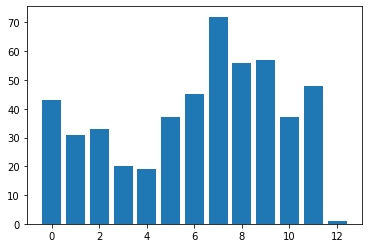

In [38]:
percentage = 0.05
top_neurons = ordering[:int(percentage*len(ordering))]
layerWidth = 768
layerDepth = 13
layers = [0] * layerDepth
layerIndex = list (range(0, layerDepth))
for i in top_neurons:
    layerNum = int(i/layerWidth)
    layers[layerNum] = layers[layerNum] + 1

plt.bar(layerIndex, layers)
plt.show()
    
#for idx, val in enumerate(layers):
 #   print("Layer " + str(idx) + " contributes " + str(val))
    #print (val)


# Layer-wise Probe Accuracy (with retraining)

Selecting from Layer 1
768 13
Including neurons from f1(#0 to #768)
Including neurons from f1(#0 to #768)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
length of source dictionary:  19649
length of targ


Epoch: [1/1], Loss: 0.0029



Score (accuracy) of the model: 0.8710
Selecting from Layer 2
768 13
Including neurons from f2(#768 to #1536)
Including neurons from f2(#768 to #1536)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
lengt


Epoch: [1/1], Loss: 0.0025



Score (accuracy) of the model: 0.8981
Selecting from Layer 3
768 13
Including neurons from f3(#1536 to #2304)
Including neurons from f3(#1536 to #2304)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
len


Epoch: [1/1], Loss: 0.0019



Score (accuracy) of the model: 0.9331
Selecting from Layer 4
768 13
Including neurons from f4(#2304 to #3072)
Including neurons from f4(#2304 to #3072)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
len


Epoch: [1/1], Loss: 0.0017



Score (accuracy) of the model: 0.9418
Selecting from Layer 5
768 13
Including neurons from f5(#3072 to #3840)
Including neurons from f5(#3072 to #3840)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
len


Epoch: [1/1], Loss: 0.0017



Score (accuracy) of the model: 0.9460
Selecting from Layer 6
768 13
Including neurons from f6(#3840 to #4608)
Including neurons from f6(#3840 to #4608)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
len


Epoch: [1/1], Loss: 0.0016



Score (accuracy) of the model: 0.9497
Selecting from Layer 7
768 13
Including neurons from f7(#4608 to #5376)
Including neurons from f7(#4608 to #5376)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
len


Epoch: [1/1], Loss: 0.0016



Score (accuracy) of the model: 0.9488
Selecting from Layer 8
768 13
Including neurons from f8(#5376 to #6144)
Including neurons from f8(#5376 to #6144)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
len


Epoch: [1/1], Loss: 0.0017



Score (accuracy) of the model: 0.9495
Selecting from Layer 9
768 13
Including neurons from f9(#6144 to #6912)
Including neurons from f9(#6144 to #6912)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737
len


Epoch: [1/1], Loss: 0.0018



Score (accuracy) of the model: 0.9474
Selecting from Layer 10
768 13
Including neurons from f10(#6912 to #7680)
Including neurons from f10(#6912 to #7680)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737



Epoch: [1/1], Loss: 0.0019



Score (accuracy) of the model: 0.9461
Selecting from Layer 11
768 13
Including neurons from f11(#7680 to #8448)
Including neurons from f11(#7680 to #8448)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737



Epoch: [1/1], Loss: 0.0021



Score (accuracy) of the model: 0.9427
Selecting from Layer 12
768 13
Including neurons from f12(#8448 to #9216)
Including neurons from f12(#8448 to #9216)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737



Epoch: [1/1], Loss: 0.0023



Score (accuracy) of the model: 0.9397
Selecting from Layer 13
768 13
Including neurons from f13(#9216 to #9984)
Including neurons from f13(#9216 to #9984)
Creating train tensors...
Number of tokens:  199207
length of source dictionary:  19649
length of target dictionary:  17
199207
Total instances: 199207
['partnership', 'Crim', 'DAUGHTER', 'equivalant', 'SE', 'Conservative', 'sniffing', 'Bio', 'caught', 'ate', 'trimmers', '1542', 'discretion', 'Claude', 'sulfur', 'Meanwhile', 'arbitrators', 'finish', 'dear', 'straight']
Number of tokens:  24904
length of source dictionary:  19649
length of target dictionary:  17
24904
Total instances: 24904
['http://www.google.co.uk/search?q=forensic+photography&ie=utf-8&oe=utf-8&aq=t&rls=org.mozilla:en-US:official&client=firefox-a&safe=active&sout=1', 'ate', 'discretion', 'Urban', 'straight', 'dear', 'join', 'bit', 'Harvey', 'smart', 'smooth', 'L', 'gifts', 'beat', 'occupied', 'appear', 'stayed', 'begin', 'answer', 'smell']
Number of tokens:  24737



Epoch: [1/1], Loss: 0.0032



Score (accuracy) of the model: 0.9283


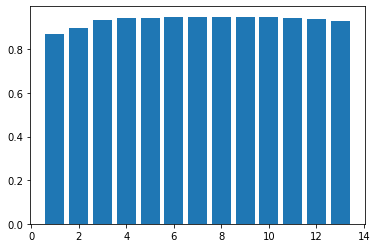

In [39]:
layerAccuracy = [0] * layerDepth
layerIndex = list (range(1, layerDepth+1))


for layer in range(1, NUM_LAYERS+1):
    
    print ("Selecting from Layer " + str(layer))
    filter_layers="f" + str(layer)
    print(NUM_NEURONS_PER_LAYER, NUM_LAYERS)
    f_train_activations, f_test_activations = utils.filter_activations_by_layers(train_activations, test_activations, filter_layers, NUM_NEURONS_PER_LAYER, NUM_LAYERS, IS_BRNN)
    f_train_activations, f_dev_activations = utils.filter_activations_by_layers(train_activations, dev_activations, filter_layers, NUM_NEURONS_PER_LAYER, NUM_LAYERS, IS_BRNN)

    print("Creating train tensors...")
    X_filtered, y, mappings = utils.create_tensors(train_tokens, f_train_activations, TASK_SPECIFIC_TAG)
    X_dev_filtered, y_dev, mappings = utils.create_tensors(dev_tokens, f_dev_activations, TASK_SPECIFIC_TAG, mappings)
    X_test_filtered, y_test, mappings = utils.create_tensors(test_tokens, f_test_activations, TASK_SPECIFIC_TAG, mappings)
    label2idx, idx2label, src2idx, idx2src = mappings
    
    print("Building model...")
    
    model_filtered = utils.train_logreg_model(X_filtered, y, lambda_l1=0, lambda_l2=0, num_epochs=1, batch_size=BATCH_SIZE)
    #overall_train_accuracies = utils.evaluate_model(model_filtered, X_filtered, y, idx2label)
    #overall_dev_accuracies = utils.evaluate_model(model_filtered, X_dev_filtered, y_dev, idx2label)
    overall_test_accuracies, predictions = utils.evaluate_model(model_filtered, X_test_filtered, y_test, idx2label, return_predictions=True, source_tokens=test_tokens['source'])
    layerAccuracy[layer-1] = overall_test_accuracies['__OVERALL__']
    
plt.bar(layerIndex, layerAccuracy)
plt.show()

# Spread of Neurons per property

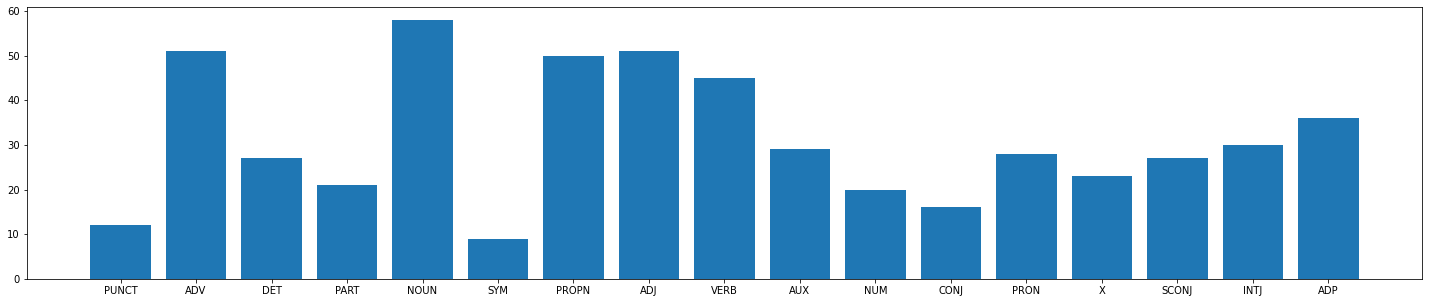

In [41]:
percentage=0.05
ordering, cutoffs = utils.get_neuron_ordering(model, label2idx, search_stride=1000)
top_neurons_global = ordering[:int(percentage*len(ordering))]
fac = 1
top_neurons_local = []

while (len(top_neurons_local) < len(top_neurons_global)):
    top_neurons_local, classWise = utils.get_top_neurons(model, percentage*fac, label2idx)
    fac = fac + 0.1

properties = []
numNeurons = []

for k, v in classWise.items():
    #print (k, v)
    properties.append(k)
    numNeurons.append(len(v))
plt.figure(figsize=(25,5))
plt.bar(properties, numNeurons)
plt.show()

# Spread of Neurons per layer per property


PUNCT


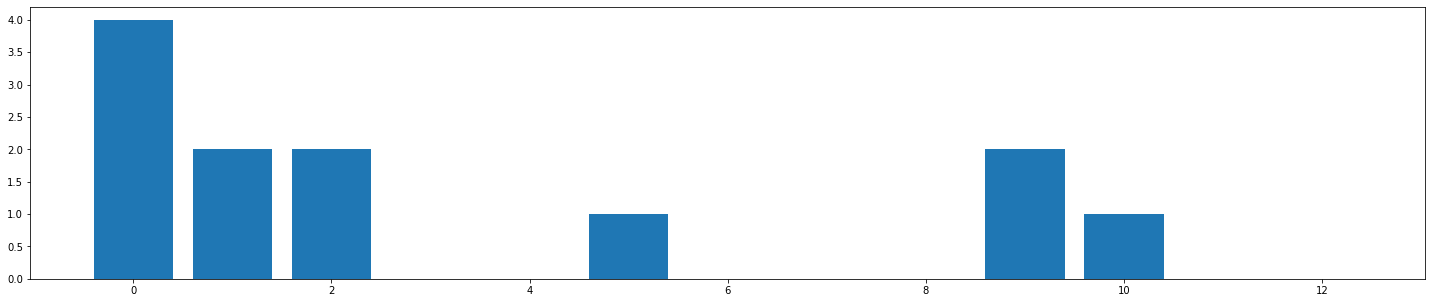

ADV


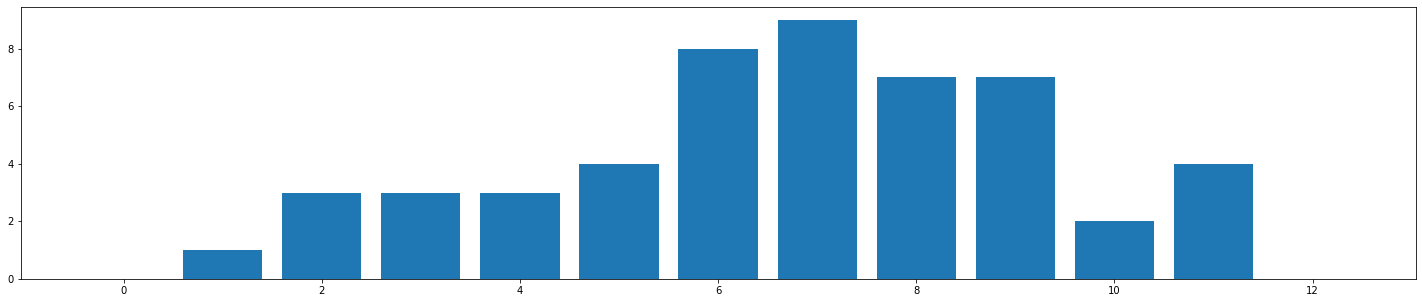

DET


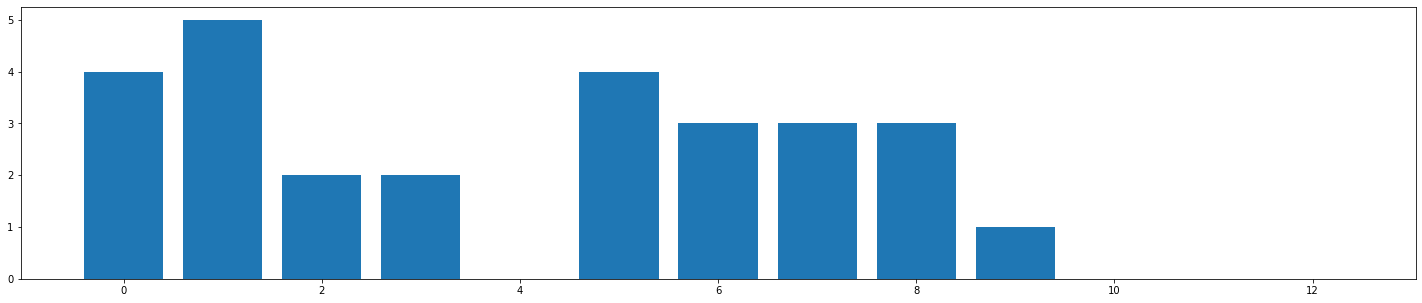

PART


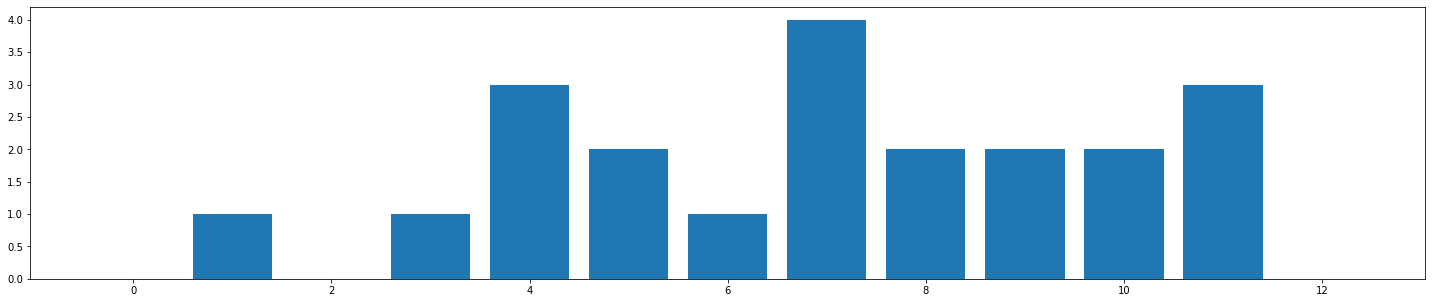

NOUN


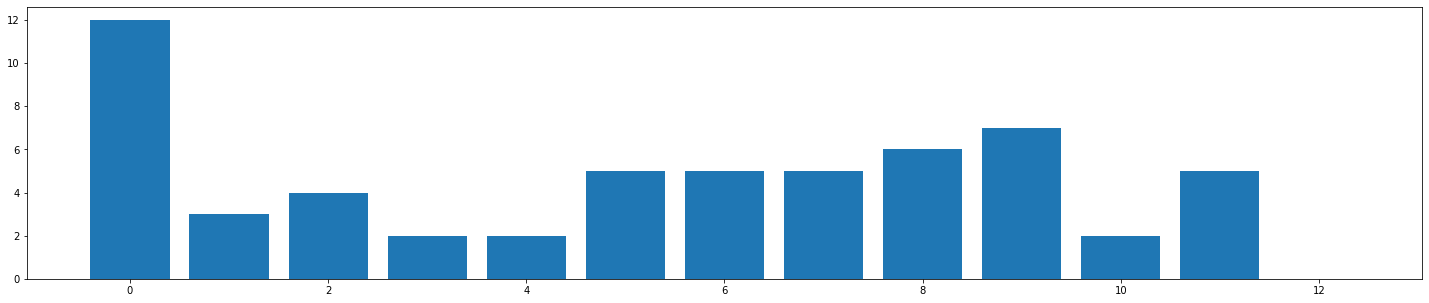

SYM


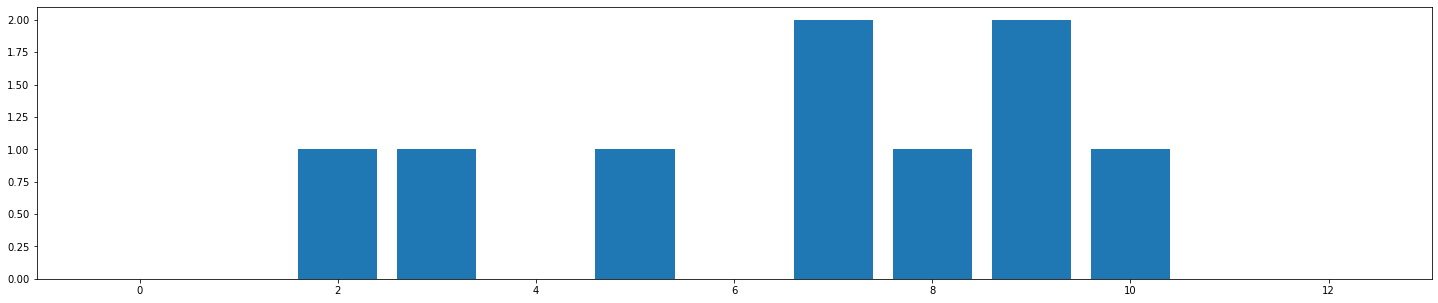

PROPN


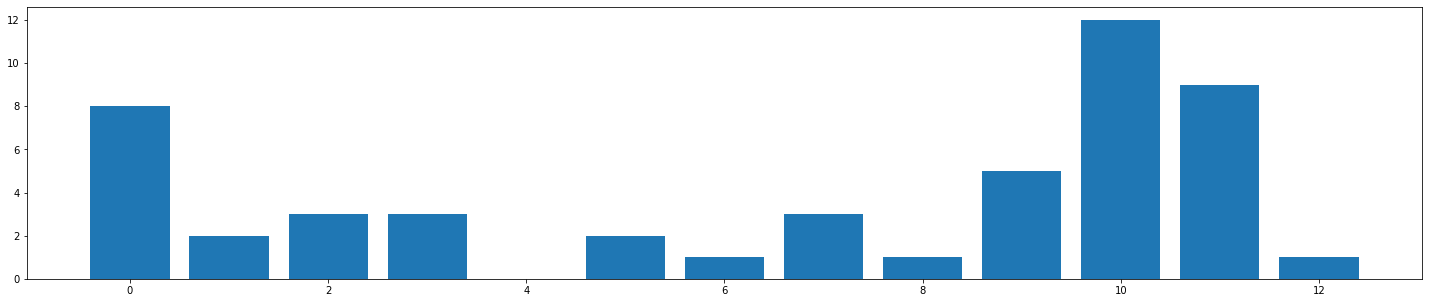

ADJ


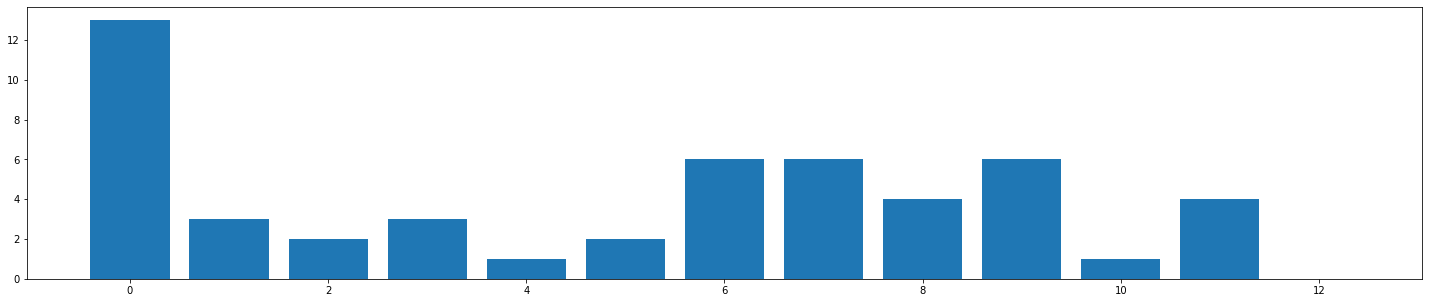

VERB


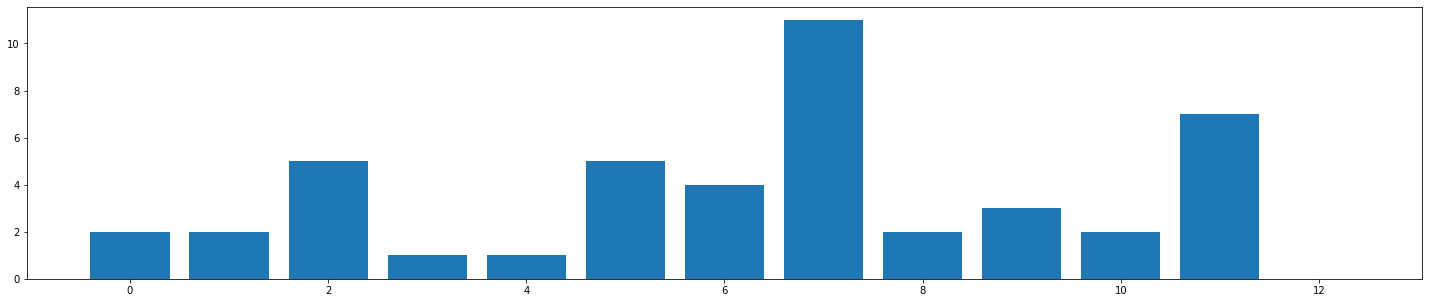

AUX


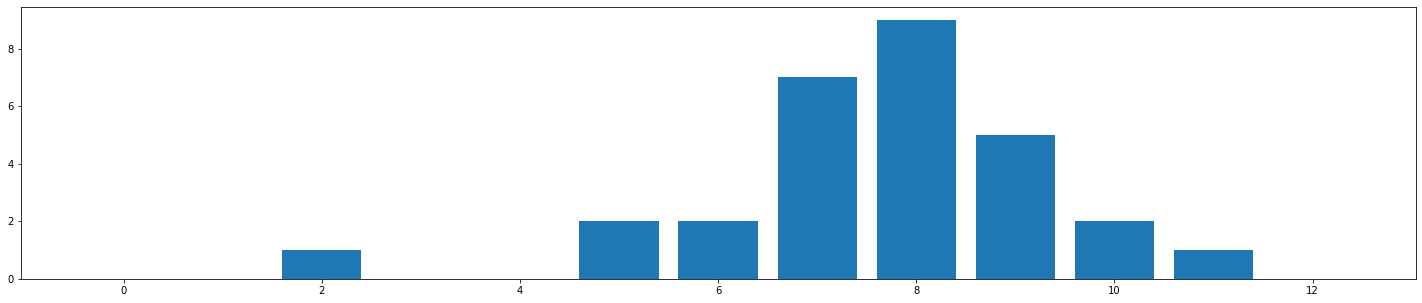

NUM


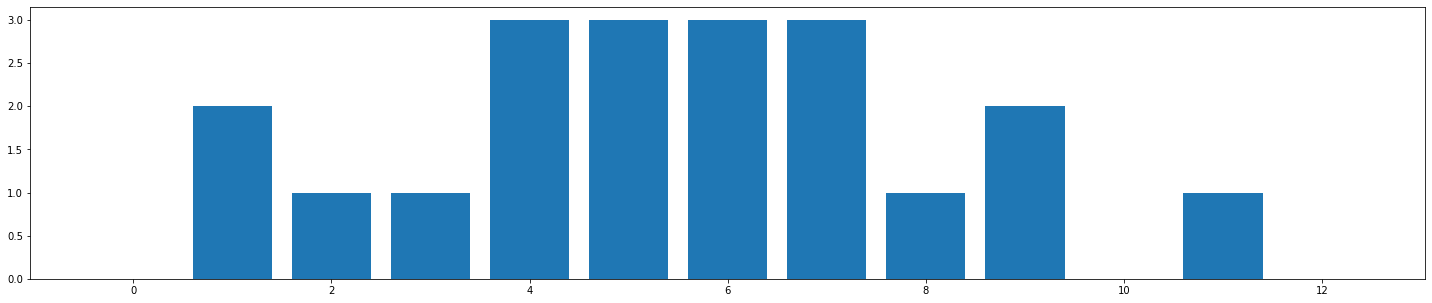

CONJ


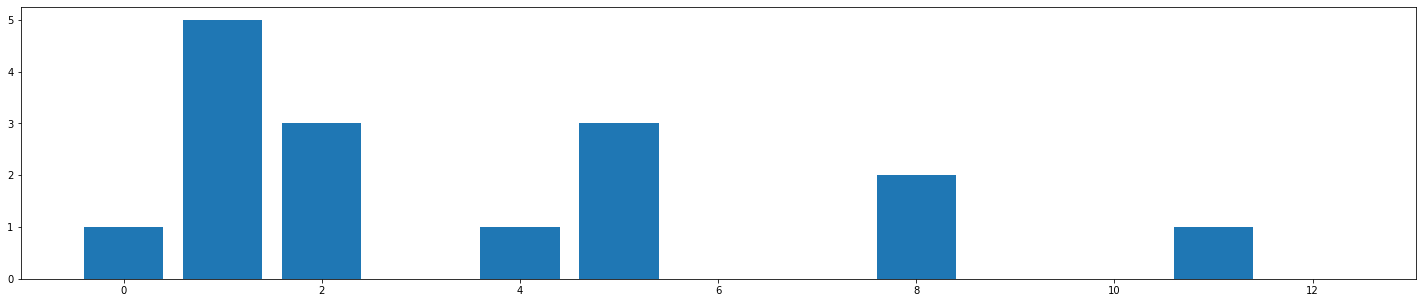

PRON


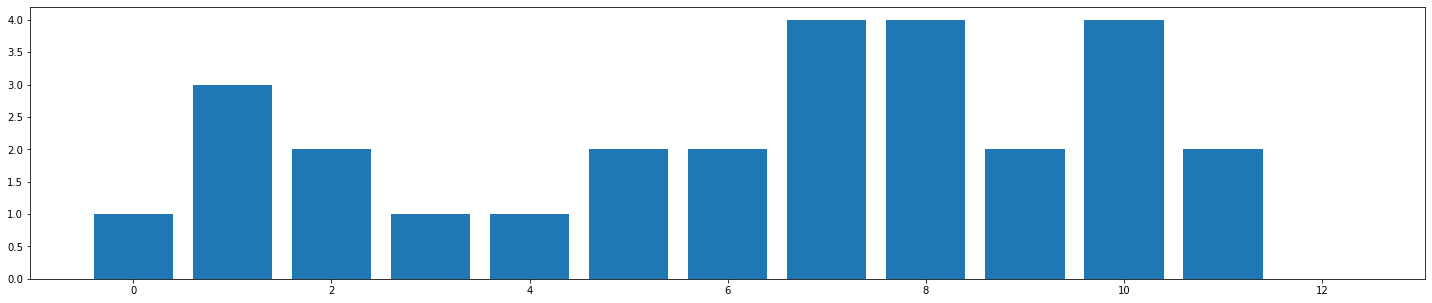

X


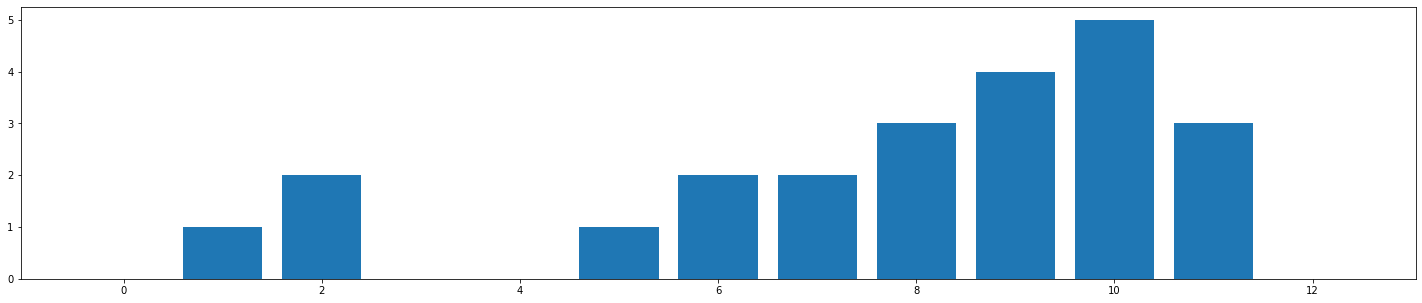

SCONJ


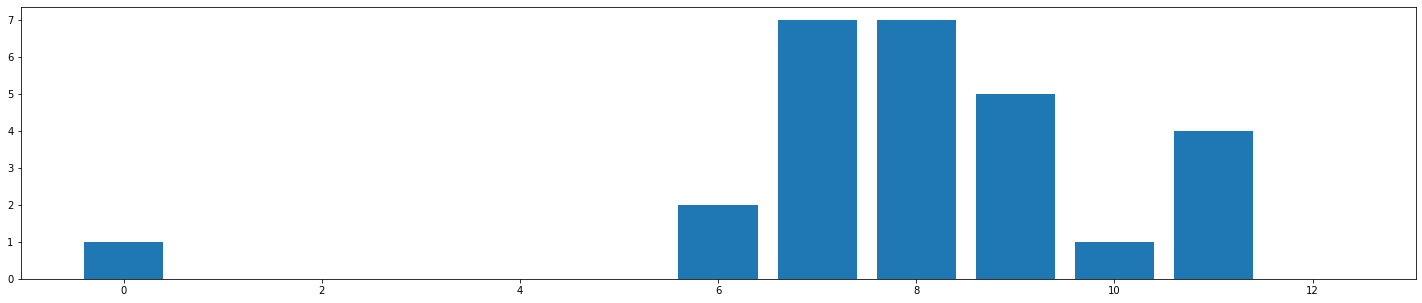

INTJ


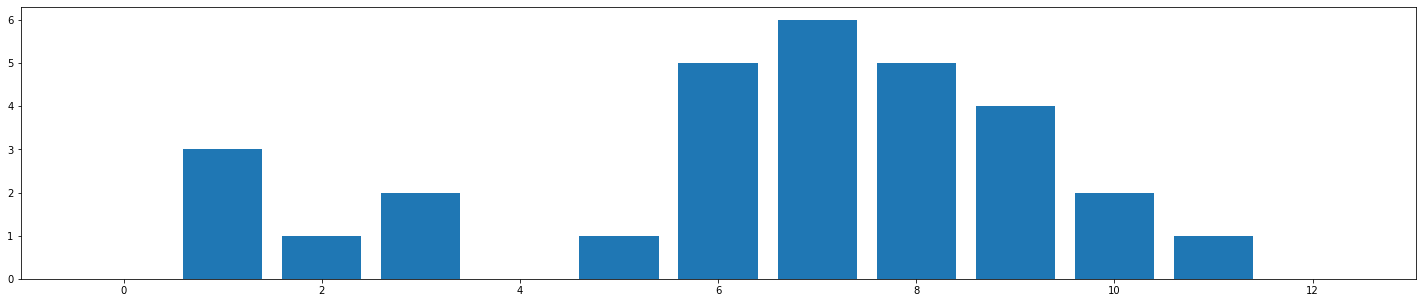

ADP


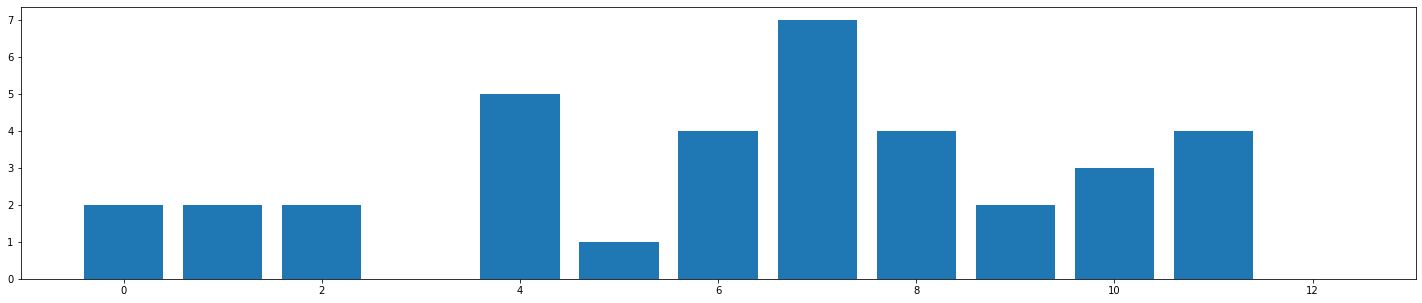

In [42]:
percentage=0.05
ordering, cutoffs = utils.get_neuron_ordering(model, label2idx, search_stride=1000)
top_neurons_global = ordering[:int(percentage*len(ordering))]
fac = 1
top_neurons_local = []

while (len(top_neurons_local) < len(top_neurons_global)):
    top_neurons_local, classWise = utils.get_top_neurons(model, percentage*fac, label2idx)
    fac = fac + 0.1

properties = []
numNeurons = []

layerWidth = 768
layerDepth = 13
winner = list (range(0, layerDepth))

for k, v in classWise.items():
    layers = [0] * layerDepth
    for i in v:
        layerNum = int(i/layerWidth)
        layers[layerNum] = layers[layerNum] + 1
    
    print (k)
    plt.figure(figsize=(25,5))
    plt.bar(winner, layers)
    plt.show()
    
    
   

In [44]:
percentage=0.05
ordering, cutoffs = utils.get_neuron_ordering(model, label2idx, search_stride=1000)
top_neurons_global = ordering[:int(percentage*len(ordering))]
fac = 1
top_neurons_local = []

while (len(top_neurons_local) < len(top_neurons_global)):
    top_neurons_local, classWise = utils.get_top_neurons(model, percentage*fac, label2idx)
    fac = fac + 0.1

layerWidth = 768
layerDepth = 13
winner = [0] * layerDepth


for k, v in classWise.items():
    layers = [0] * layerDepth
    for i in v:
        layerNum = int(i/layerWidth)
        layers[layerNum] = layers[layerNum] + 1
    
    max = 0
    maxVal = 0
    print (k, end = ',' )
    
    for idx, val in enumerate(layers):
        print(val , end = ','),
        if (val > maxVal):
            max = idx
            maxVal = val
    winner[max] = winner[max] +1
    print (max, '\n')

print ("Winner", end = ',')
for i, j in enumerate (winner):
    print (j, end = ',')

PUNCT,4,2,2,0,0,1,0,0,0,2,1,0,0,0 

ADV,0,1,3,3,3,4,8,9,7,7,2,4,0,7 

DET,4,5,2,2,0,4,3,3,3,1,0,0,0,1 

PART,0,1,0,1,3,2,1,4,2,2,2,3,0,7 

NOUN,12,3,4,2,2,5,5,5,6,7,2,5,0,0 

SYM,0,0,1,1,0,1,0,2,1,2,1,0,0,7 

PROPN,8,2,3,3,0,2,1,3,1,5,12,9,1,10 

ADJ,13,3,2,3,1,2,6,6,4,6,1,4,0,0 

VERB,2,2,5,1,1,5,4,11,2,3,2,7,0,7 

AUX,0,0,1,0,0,2,2,7,9,5,2,1,0,8 

NUM,0,2,1,1,3,3,3,3,1,2,0,1,0,4 

CONJ,1,5,3,0,1,3,0,0,2,0,0,1,0,1 

PRON,1,3,2,1,1,2,2,4,4,2,4,2,0,7 

X,0,1,2,0,0,1,2,2,3,4,5,3,0,10 

SCONJ,1,0,0,0,0,0,2,7,7,5,1,4,0,7 

INTJ,0,3,1,2,0,1,5,6,5,4,2,1,0,7 

ADP,2,2,2,0,5,1,4,7,4,2,3,4,0,7 

Winner,3,2,0,0,1,0,0,8,1,0,2,0,0,